In [300]:
import numpy as np
import matplotlib.pyplot as plt  # 导入Matplotlib库
from mpl_toolkits.mplot3d import Axes3D

以下为计算成对距离的函数，它的原理是：对于每个点，计算它与其他点的距离，然后取最小的距离作为它的成对距离。这样，每个点都有一个成对距离，然后取所有点的成对距离的平均值作为最终的成对距离。

In [301]:
# 计算成对距离的函数
def pairwise_distances(X):
    dist_matrix = np.sqrt(np.sum((X[:, None] - X) ** 2, axis=2))
    return dist_matrix

In [302]:
# 计算最近邻的索引
def nearest_neighbors(X, k):
    dist_matrix = pairwise_distances(X)
    return dist_matrix.argsort(axis=1)[:, 1:k+1]

In [303]:
def construct_adjacency_matrix(X, method, epsilon, n_neighbors):
    n = len(X)  # 计算数据集样本点的数量
    adjacency_matrix = np.zeros((n, n))  # 创建一个全零的邻接矩阵，尺寸为 (n, n)
    t=100
    if method == 'E':  # 如果方法为epsilon邻域
        for i in range(n):  # 对于数据集中的每个样本点 i
            for j in range(n):  # 对于数据集中的每个样本点 j
                if np.linalg.norm(X[i] - X[j]) < epsilon:  # 如果样本点 i 和 j 之间的距离小于 epsilon
                    adjacency_matrix[i, j] = np.exp(- np.linalg.norm(X[i] - X[j]) ** 2 / t)  # 使用热核方法计算权重
                    adjacency_matrix[j, i] = np.exp(- np.linalg.norm(X[j] - X[i]) ** 2 / t)  #邻接矩阵为对称矩阵

    elif method == 'knn':  # 如果方法为k最近邻
        dist_matrix = pairwise_distances(X)  # 计算数据集中样本点之间的距离
        np.savetxt('dist_matrix.csv', dist_matrix, delimiter=',')
        knn_matrix = nearest_neighbors(X, n_neighbors)  # 计算每个样本点的 n_neighbors 个最近邻索引
        np.savetxt('knn_matrix.csv', knn_matrix, delimiter=',')
        for i in range(len(X)):  # 对于数据集中的每个样本点 i
            for j in knn_matrix[i]:  # 对于样本点 i 的 n_neighbors 个最近邻点 j
                adjacency_matrix[i][int(j)] = np.exp(- dist_matrix[i][int(j)] ** 2 / t)  # 使用热核方法计算权重
                adjacency_matrix[int(j)][i] = np.exp(- dist_matrix[int(j)][i] ** 2 / t)  #邻接矩阵为对称矩阵

    return adjacency_matrix  # 返回构建完成的邻接矩阵

In [304]:
# 计算度矩阵和拉普拉斯矩阵
def compute_laplacian(adjacency_matrix):
    degree_matrix = np.diag(np.sum(adjacency_matrix, axis=1))

    np.savetxt('degree_matrix.csv', degree_matrix, delimiter=',')
    
    laplacian_matrix = degree_matrix - adjacency_matrix
    return laplacian_matrix

In [305]:
# 解决广义特征值问题
def solve_generalized_eigenproblem(X, L, D, n_components):
    # 计算广义特征值问题的特征向量和特征值
    eigenvalues, eigenvectors = np.linalg.eigh(np.linalg.pinv(D) @ L)
    # 选择前 n_components 个特征向量对应的特征值
    indices = np.argsort(eigenvalues)[:n_components]
    return eigenvectors[:, indices]

In [306]:
# 构建映射矩阵
def construct_mapping_matrix(eigenvectors):
    return eigenvectors

In [307]:
# LPP算法
def LPP(X, n_neighbors, n_components, method):
    # Step 1: 构建邻接图
    adjacency_matrix = construct_adjacency_matrix(X, method, epsilon=0.5, n_neighbors=n_neighbors)

    np.savetxt('adjacency_matrix.csv', adjacency_matrix, delimiter=',')

    # Step 2: 计算拉普拉斯矩阵
    laplacian_matrix = compute_laplacian(adjacency_matrix)

    np.savetxt('laplacian_matrix.csv', laplacian_matrix, delimiter=',')

    # Step 4: 解决广义特征值问题
    embedding = solve_generalized_eigenproblem(X, laplacian_matrix, np.diag(np.sum(laplacian_matrix, axis=1)), n_components)

    np.savetxt('embedding.csv', embedding, delimiter=',')

    # Step 5: 构建映射矩阵
    mapping_matrix = construct_mapping_matrix(embedding)

    np.savetxt('mapping_matrix.csv', mapping_matrix, delimiter=',')
    
    # Step 6: 计算投影矩阵
    mapping_matrix=np.transpose(mapping_matrix)
    return mapping_matrix

In [308]:
# 示例数据
X = np.load('D:/OneDrive - email.szu.edu.cn/Manifold Learning/swiss roll-1000.npy')

np.savetxt('X.csv', X, delimiter=',')

# 将 X 格式化为 (n_samples, n_features)
X_trans = np.transpose(X)

np.savetxt('X_trans.csv', X_trans, delimiter=',')

# 设置参数
n_neighbors = 50
n_components = 2
method = 'k_nearest_neighbors'
# 执行LPP算法
lpp_embeddings = LPP(X_trans, n_neighbors=n_neighbors, n_components=n_components, method=method)

# 保存数据集 lpp_embeddings 到文件

np.savetxt('lpp_embeddings.csv', lpp_embeddings, delimiter=',')

In [309]:
import pandas as pd
csvs = ['X.csv', 'X_trans.csv', 'dist_matrix.csv', 'adjacency_matrix.csv', 'degree_matrix.csv', 'laplacian_matrix.csv', 'embedding.csv', 'lpp_embeddings.csv', ]
for csv in csvs:
    df = pd.read_csv(csv, header=None)
    dimension = df.shape
    print(f"Dimension of {csv}: {dimension}")

Dimension of X.csv: (3, 1000)
Dimension of X_trans.csv: (1000, 3)


FileNotFoundError: [Errno 2] No such file or directory: 'dist_matrix.csv'

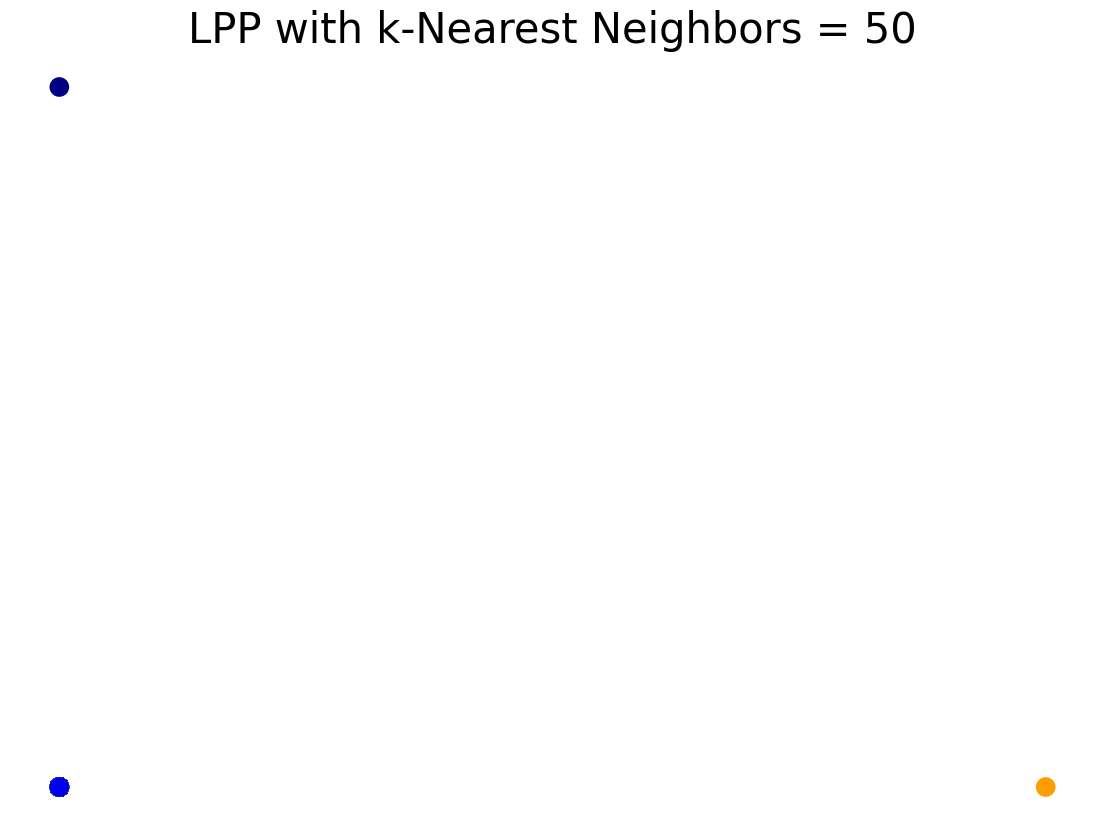

In [ ]:
# 绘制投影图
plt.figure(figsize=(14,10))
plt.scatter(lpp_embeddings[:, 0], lpp_embeddings[:, 1], c=plt.cm.jet((X_trans[:,0]**2+X_trans[:,2]**2)/100), s=200, lw=0, alpha=1)
plt.title('LPP with k-Nearest Neighbors = ' + str(n_neighbors), size=30)
plt.axis("off")
plt.show()